In [9]:
import torch
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np


In [150]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean and std for MNIST
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [151]:
#one hot encoding and crating custom dataset
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y]

class MyDataset(Dataset):
    def __init__(self, data, label): 
        self.data = data
        self.labels = label 
        # self.labels = one_hot_encode(label, num_classes=10).astype(np.float32) # Old one-hot encoding

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx].float() / 255.0 
        x = (x - 0.1307) / 0.3081           
        y = self.labels[idx] # Return class index
        return x, y


        
    
X_train,y_train = train_dataset.data, train_dataset.targets
X_test,y_test = test_dataset.data,test_dataset.targets

train_d = MyDataset(X_train,y_train)
test_d = MyDataset(X_test,y_test)

train_loader = DataLoader(train_d, batch_size=64, shuffle=True)
test_loader = DataLoader(test_d,batch_size=64,shuffle=True)


In [163]:
for image,target in train_loader:
    print(target.shape)
    break

torch.Size([64])


In [153]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,padding=2,kernel_size=5,out_channels=6)
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)

        self.fc1 = nn.Linear(400,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

        self.activation = nn.ReLU()

    
    def forward(self,x):

        x = self.maxpool(self.activation(self.conv1(x)))

        x = self.maxpool(self.activation(self.conv2(x)))

        x = x.view(-1,16*5*5)

        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)

        return x


In [154]:
model = LeNet()

In [179]:
model = model.to('cpu')
with torch.no_grad():
    # Assuming train_d[0][0] is a valid input tensor
    # Unsqueeze to add batch and channel dimensions
    output = model(train_d[0][0].unsqueeze(0).unsqueeze(0))
output

tensor([[-15.1190,  -6.7696, -13.0939,   4.4318, -15.2364,  15.0605,  -6.9203,
          -9.9531,  -2.6168,  -1.0315]])

In [164]:
def train(model,train_loader,optimizer,criterian,epochs,device):
    losses = []
    model.train()
    model = model.to(device)
    for epoch in range(epochs):
        running_loss = 0.0
        for images,labels in train_loader:
            optimizer.zero_grad()
            images = images.unsqueeze(1)
            images,labels = images.to(device),labels.to(device)
            output = model(images)
            loss = criterian(output,labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_epoch_loss = running_loss / len(train_loader) 
        losses.append(avg_epoch_loss) 
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_epoch_loss:.4f}")
    return losses # Return losses for plotting



In [156]:
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adjusted learning rate
criterian = nn.CrossEntropyLoss()
device = "mps" if torch.mps.is_available() else "cpu"
training_history = train(model, train_loader,optimizer=optimizer,criterian=criterian,epochs=10,device=device) # Capture history

Epoch [1/10], Loss: 0.2415
Epoch [2/10], Loss: 0.0638
Epoch [2/10], Loss: 0.0638
Epoch [3/10], Loss: 0.0461
Epoch [3/10], Loss: 0.0461
Epoch [4/10], Loss: 0.0371
Epoch [4/10], Loss: 0.0371
Epoch [5/10], Loss: 0.0283
Epoch [5/10], Loss: 0.0283
Epoch [6/10], Loss: 0.0246
Epoch [6/10], Loss: 0.0246
Epoch [7/10], Loss: 0.0220
Epoch [7/10], Loss: 0.0220
Epoch [8/10], Loss: 0.0177
Epoch [8/10], Loss: 0.0177
Epoch [9/10], Loss: 0.0161
Epoch [9/10], Loss: 0.0161
Epoch [10/10], Loss: 0.0142
Epoch [10/10], Loss: 0.0142


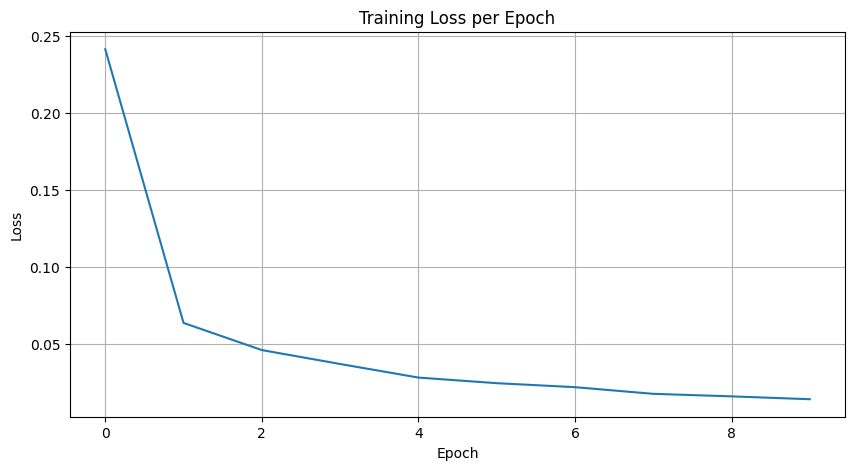

In [338]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(training_history)
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the model
def predict(model, raw_image_tensor): 
    model.eval()
    with torch.no_grad():
        processed_image = raw_image_tensor.float() / 255.0
        processed_image = (processed_image - 0.1307) / 0.3081
        processed_image = processed_image.unsqueeze(0).unsqueeze(0)  #(b,in_channels,h,w)
        processed_image = processed_image.to(device)  

        output = model(processed_image)
        _, predicted = torch.max(output, 1)
    return predicted.item()


predicted_label = predict(model, X_train[2])
print(f"Predicted label: {predicted_label}")
print(f"Actual label: {y_train[2]}")

Predicted label: 4
Actual label: 4


In [182]:
#calculate accuracy
def calculate_accuracy(model, data_loader, device):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.unsqueeze(1).to(device)  
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total * 100
    return accuracy


# Calculating accuracy on training and test datasets
train_accuracy = calculate_accuracy(model, train_loader, device)
test_accuracy = calculate_accuracy(model, test_loader, device)

In [183]:
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Training Accuracy: 99.71%
Test Accuracy: 99.05%


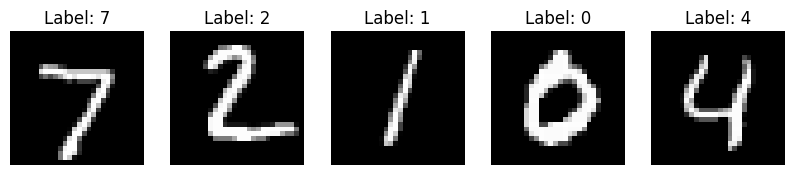

In [184]:
fig = plt.figure(figsize=(10, 5))



for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(X_test[i], cmap='gray')
    ax.set_title(f"Label: {y_test[i]}")
    ax.axis('off')

    

In [185]:
from sklearn.metrics import confusion_matrix

In [215]:
y_pred = []

with torch.no_grad():
    for images, labels in test_dataset:
        images = images.unsqueeze(1).to(device)  
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.append(predicted)

y_pred

[tensor([7], device='mps:0'),
 tensor([2], device='mps:0'),
 tensor([1], device='mps:0'),
 tensor([0], device='mps:0'),
 tensor([4], device='mps:0'),
 tensor([1], device='mps:0'),
 tensor([4], device='mps:0'),
 tensor([9], device='mps:0'),
 tensor([5], device='mps:0'),
 tensor([9], device='mps:0'),
 tensor([0], device='mps:0'),
 tensor([6], device='mps:0'),
 tensor([9], device='mps:0'),
 tensor([0], device='mps:0'),
 tensor([1], device='mps:0'),
 tensor([5], device='mps:0'),
 tensor([9], device='mps:0'),
 tensor([7], device='mps:0'),
 tensor([3], device='mps:0'),
 tensor([4], device='mps:0'),
 tensor([9], device='mps:0'),
 tensor([6], device='mps:0'),
 tensor([6], device='mps:0'),
 tensor([5], device='mps:0'),
 tensor([4], device='mps:0'),
 tensor([0], device='mps:0'),
 tensor([7], device='mps:0'),
 tensor([4], device='mps:0'),
 tensor([0], device='mps:0'),
 tensor([1], device='mps:0'),
 tensor([3], device='mps:0'),
 tensor([1], device='mps:0'),
 tensor([3], device='mps:0'),
 tensor([4

In [216]:
my_arr = torch.cat(y_pred).cpu().numpy()
my_arr

array([7, 2, 1, ..., 4, 5, 6], shape=(10000,))

In [217]:
cf = confusion_matrix(y_test,my_arr)

In [218]:
from seaborn import heatmap

<Axes: >

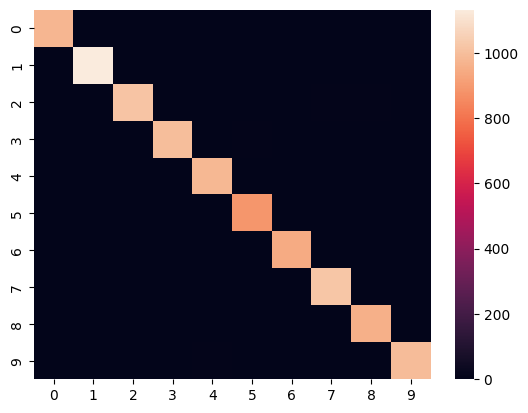

In [219]:
heatmap(cf)

In [1]:
import scipy
labels = scipy.io.loadmat("./oxford/imagelabels.mat")['labels'][0]
min(labels)

np.uint8(1)

In [2]:
setid = scipy.io.loadmat("./oxford/setid.mat")
id_dict = dict(setid)

id_dict

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009',
 '__version__': '1.0',
 '__globals__': [],
 'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]],
       shape=(1, 1020), dtype=uint16),
 'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]],
       shape=(1, 1020), dtype=uint16),
 'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]],
       shape=(1, 6149), dtype=uint16)}

In [3]:
import os
import scipy
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

class OxfordCustomDataset(Dataset):
    def __init__(self, img_dir, label_file, split_file, transform, split='train'):
        super().__init__()
        self.img_dir = img_dir
        self.transform = transform


        labels = scipy.io.loadmat(label_file)['labels'][0]
        self.labels = labels - 1

        setid = scipy.io.loadmat(split_file)
        if split == 'train':
            self.indices = setid['tstid'][0]
        elif split == 'val':
            self.indices = setid['valid'][0]
        elif split == 'test':
            self.indices = setid['trnid'][0]
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        image_id = self.indices[index]
        label = self.labels[image_id - 1]
        image_path = os.path.join(self.img_dir, f'image_{image_id:05d}.jpg')
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
]
)

train_dataset_oxford = OxfordCustomDataset(
    img_dir="oxford/jpg/",
    label_file="oxford/imagelabels.mat",
    split_file="oxford/setid.mat",
    transform=transform,
    split="train"
)

test_dataset_oxford = OxfordCustomDataset(
    img_dir="oxford/jpg/",
    label_file="oxford/imagelabels.mat",
    split_file="oxford/setid.mat",
    transform=transform,
    split="test"
)

In [10]:
train_data_loader = DataLoader(train_dataset_oxford,batch_size=64,shuffle=True)
test_data_loader = DataLoader(test_dataset_oxford,batch_size=64,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


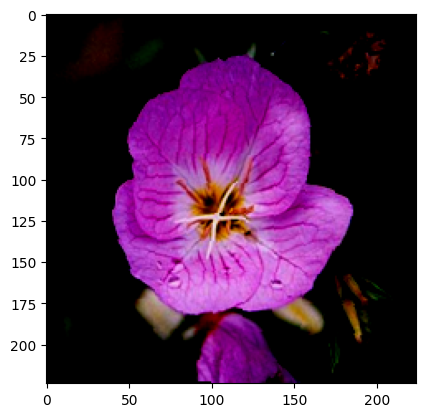

In [ ]:
for image, label in train_dataset_oxford:  # Change to (C, H, W) for visualization
    plt.imshow(image.permute(1, 2, 0).numpy())
    break

In [11]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=3, kernel_size=11, stride=4, padding=2, out_channels=96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=96, kernel_size=5, padding=2, out_channels=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=256, kernel_size=3, padding=1, out_channels=384),
            nn.ReLU(),

            nn.Conv2d(in_channels=384, kernel_size=3, padding=1, out_channels=384),
            nn.ReLU(),

            nn.Conv2d(in_channels=384, kernel_size=3, padding=1, out_channels=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Flatten(),

            nn.Linear(in_features=256 * 6 * 6, out_features=4096),
            nn.ReLU(),

            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),

            nn.Linear(in_features=4096, out_features=102) 
        )

    def forward(self,x):
        return self.classifier(x)



In [12]:
alex = AlexNet()
total_params = sum(p.numel() for p in alex.parameters())
total_params

58699238

In [13]:
def train_alex_net(model, train_loader, epochs, optimizer, criterian, device):
    model.train()
    model = model.to(device)
    losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterian(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch : {epoch+1} | Loss : {avg_loss}')
    return losses


In [ ]:
criterian = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alex.parameters(), lr=0.001)
epochs = 7
device = "mps" if torch.mps.is_available() else "cpu"

losses = train_alex_net(alex, train_data_loader, epochs, optimizer, criterian, device)

Epoch : 0 | Loss : 4.410669346445615
Epoch : 1 | Loss : 4.412752195731881
Epoch : 2 | Loss : 4.414074135809829
Epoch : 3 | Loss : 4.413027502826808
Epoch : 4 | Loss : 4.410556994762617
Epoch : 5 | Loss : 4.409014126689164
Epoch : 6 | Loss : 4.409057440217008


In [355]:
#calculate accuracy
def calculate_accuracy(model, data_loader, device):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)  
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total * 100
    return accuracy


# Calculating accuracy on training and test datasets
train_accuracy = calculate_accuracy(alex, train_data_loader, device)
print(train_accuracy)

1.1058708733127336


In [ ]:
def predict(model, raw_image_tensor): 
    model.eval()
    with torch.no_grad():
        processed_image = raw_image_tensor.float() / 255.0
        processed_image = (processed_image - 0.1307) / 0.3081
        processed_image = processed_image.unsqueeze(0).unsqueeze(0)  #(b,in_channels,h,w)
        processed_image = processed_image.to(device)  

        output = model(processed_image)
        _, predicted = torch.max(output, 1)
    return predicted.item()


predicted_label = predict(alex, X_train[2])
print(f"Predicted label: {predicted_label}")
print(f"Actual label: {y_train[2]}")

In [13]:
import torch.nn as nn
from torchvision.models import alexnet

device = torch.device("mps" if torch.mps.is_available() else "cpu")

model = alexnet(weights=True)
for param in model.features.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(4096, 102)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

/Users/boss_07/Documents/statistics/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
#unfreeze few features 
# for param in model.features[6:12].parameters():
#     param.requires_grad = True
model.features[6:12].requires_grad_(True) 
model = model.to(device)

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
model = model.to(device)

def train(model, loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(loader):.4f}")

In [19]:
train(model, train_data_loader, optimizer, criterion, epochs=10)


Epoch 1, Loss: 2.2031
Epoch 2, Loss: 0.7704
Epoch 3, Loss: 0.4964
Epoch 4, Loss: 0.3669
Epoch 5, Loss: 0.2943
Epoch 6, Loss: 0.2213
Epoch 7, Loss: 0.1920
Epoch 8, Loss: 0.1573
Epoch 9, Loss: 0.1337
Epoch 10, Loss: 0.1051


In [22]:

# Accuracy evaluation
def accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

print(f"Test Accuracy: {accuracy(model, test_data_loader) * 100:.2f}%")

Test Accuracy: 82.55%


In [2]:
from torchvision import models


In [22]:
gnet = models.GoogLeNet(num_classes=100,init_weights=True)

In [25]:
total_params = sum(p.numel() for p in gnet.parameters())
total_params

10237388